In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install --upgrade scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler 

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [3]:
df = pd.read_csv("/kaggle/input/prediction-of-surgery-duration/train.csv",encoding='Latin-1')
df.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second)
0,1829,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333
1,1104,{'N20.1'},{'C'},Spinal Anestezi,NaN,24,MALE,ÜROLOJ? SERV?S?,15,3,2972
2,1850,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647
3,1059,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871
4,608,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046


In [4]:
# ID Colonunun silinmesi:
df.drop("ID", axis=1,inplace = True)

In [5]:
df.head()

,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second)
0,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333
1,{'N20.1'},{'C'},Spinal Anestezi,NaN,24,MALE,ÜROLOJ? SERV?S?,15,3,2972
2,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647
3,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046


# EDA

## HEDEF DEĞİŞKEN ANALİZİ:


In [6]:
df["ElapsedTime(second)"].value_counts()

1645    4
1962    4
3530    4
4101    4
3278    4
       ..
6534    1
3545    1
1708    1
6849    1
5690    1
Name: ElapsedTime(second), Length: 2330, dtype: int64

In [7]:
df["ElapsedTime(second)"].nunique()

2330

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': round(100 * (dataframe[col_name].value_counts()) / len(dataframe), 2)}))

    if plot:
        sns.displot(x=col_name,data=dataframe, kde=True)
        plt.title(col_name + ' Histogram Grafiği')
        plt.show()
        sns.stripplot(dataframe, y=col_name, jitter=True, color='purple', alpha=0.5)
        plt.ylabel(col_name)
        plt.title(col_name + ' Nokta Grafiği')
        

      ElapsedTime(second)  Ratio
1645                    4   0.14
1962                    4   0.14
3530                    4   0.14
4101                    4   0.14
3278                    4   0.14
...                   ...    ...
6534                    1   0.04
3545                    1   0.04
1708                    1   0.04
6849                    1   0.04
5690                    1   0.04

[2330 rows x 2 columns]


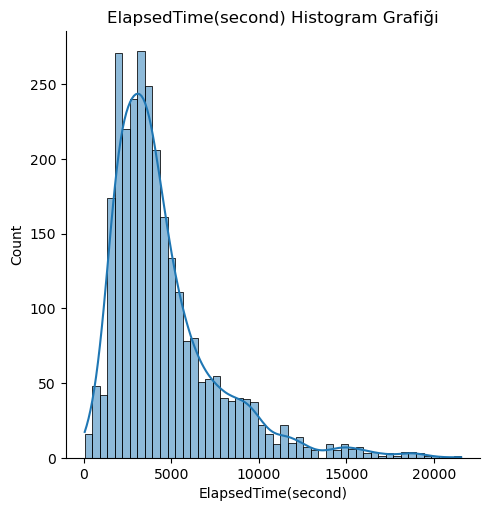

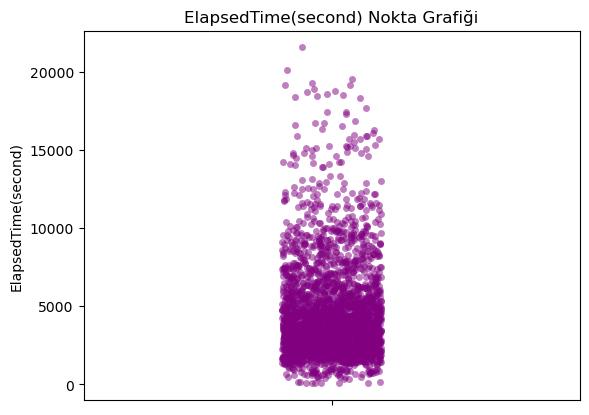

In [9]:
cat_summary(df,"ElapsedTime(second)", plot=True)

Gördüğünüz gibi, çizimde Elapsed Time (Geçen Süre) değerlerinin yoğunluğu sağa doğru ciddi şekilde azalmaktadır. Bu, Elapsed Time değerlerinin sağa çarpık (pozitif çarpıklık) olduğunu gösterir. Pozitif çarpıklık, veri dağılımının sağ kısmının sol kısmına göre daha uzun olduğu durumlarda meydana gelir.

Bu durumda, tahmin değerlerimizin Elapsed Time değerlerinin ortalaması yerine ortancası civarında olması gerektiği anlamına gelir. Çünkü Elapsed Time değerlerinin ortancası, dağılımın yoğunluğunun en yüksek olduğu bölgedir. 

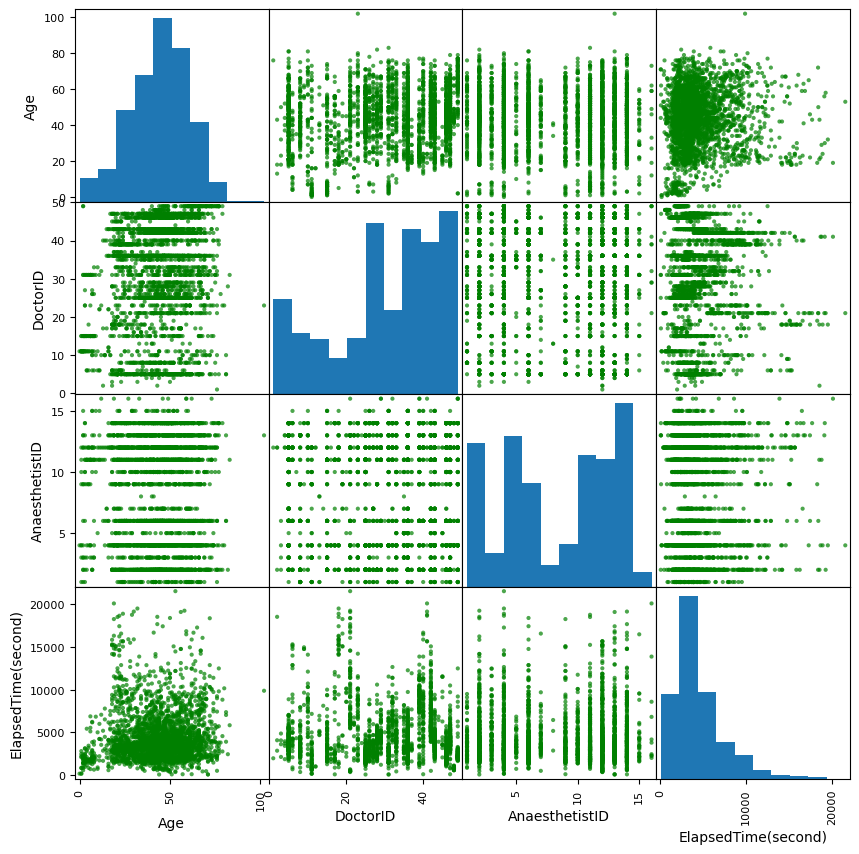

In [10]:
pd.plotting.scatter_matrix(df, figsize=(10,10), diagonal='hist', alpha=0.7, color='g')
plt.show()

In [11]:
import plotly.express as px

fig = px.scatter(df, x=df.index, y="ElapsedTime(second)", color="DoctorID",
                 size='ElapsedTime(second)', hover_data=['ElapsedTime(second)'],
                 labels={"ElapsedTime(second)": "Elapsed Time (seconds)", "index": "Sample Number"},
                 color_discrete_sequence=px.colors.qualitative.Dark24,
                 
                 )

fig.update_layout(title='Örnek Numarasına Göre Geçen Süre',
                  xaxis=dict(title='Örnek Numarası'),
                  yaxis=dict(title='Elapsed Time (seconds)'))

fig.show() 

# Data Overview


In [12]:
# Check Dataset:

def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe().T)
check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DiagnosticICD10Code  2601 non-null   object
 1   SurgeryGroup         2822 non-null   object
 2   AnesthesiaType       2601 non-null   object
 3   SurgeryName          2447 non-null   object
 4   Age                  2822 non-null   int64 
 5   Sex                  2822 non-null   object
 6   Service              2822 non-null   object
 7   DoctorID             2822 non-null   int64 
 8   AnaesthetistID       2822 non-null   int64 
 9   ElapsedTime(second)  2822 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 220.6+ KB
None
--------------------     Data Shape     --------------------
(2822, 10)

--------------------  The First 5 Data  --------------------
       DiagnosticICD10Code              SurgeryGroup 

In [13]:
df["AnesthesiaType"].value_counts()

Genel Anestezi                         1076
Sedo Analjezi                           804
Spinal Anestezi                         627
Lokal Anestezi                           60
Rejyonel Sinir Blo?u                     14
Epidural ve Genel Anestezi                9
Periferik Bloklar                         4
Epidural Anestezi                         2
Spinal ve Genel Anestezi                  2
Seçilmemi?                                1
Kombine Spinal Epidural Anestezi          1
Periferik Bloklar ve Genel Anestezi       1
Name: AnesthesiaType, dtype: int64

In [14]:
# AnesthesiaType sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df["AnesthesiaType"].isnull().sum().astype(str))

df["AnesthesiaType"].fillna("Genel Anestezi", inplace=True)

print("Boşluk doldurma sonrası boş değer sayısı:" + df["AnesthesiaType"].isnull().sum().astype(str))


Boşluk doldurma öncesi boş değer sayısı:221
Boşluk doldurma sonrası boş değer sayısı:0


In [15]:

df["SurgeryName"].value_counts()

Ülser veya enflamasyon olmadan alt ekstremitenin variköz venleri                         371
Bilateral inguinal herni, obstrüksiyonsuz veya gangrensiz                                228
Kolelitiazis, di?er                                                                      210
Lumbar ve di?er intervertebral disk bozukluklar?, radikülopati ile                       108
Pilonidal kist                                                                            81
                                                                                        ... 
Klavikula k?r???                                                                           1
D?? protez arac?n?n tan?mlanmam?? uygulamas?                                               1
Servikal disk bozuklu?u, tan?mlanmam?? | Servikal disk bozukluklar?, radikülopati ile      1
Otalji                                                                                     1
Abdominal herni, obstrüksiyon ve gangrensiz tan?mlanmam??             

In [16]:
# SurgeryName sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df["SurgeryName"].isnull().sum().astype(str))
df['SurgeryName'] = df['SurgeryName'].fillna(df['SurgeryName'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df["SurgeryName"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:375
Boşluk doldurma sonrası boş değer sayısı:0


In [17]:
df["DiagnosticICD10Code"].value_counts()

{'I83.9'}                220
{'K80.8'}                182
{'I83'}                  148
{nan, 'M51.1'}           105
{'K40.9'}                 95
                        ... 
{'L60.8'}                  1
{'S92.5'}                  1
{nan, 'K21', 'M17.9'}      1
{'S52.2'}                  1
{'Z41.1', 'Z00.0'}         1
Name: DiagnosticICD10Code, Length: 504, dtype: int64

In [18]:
# DiagnosticICD10Code sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df["DiagnosticICD10Code"].isnull().sum().astype(str))
df['DiagnosticICD10Code'] = df['DiagnosticICD10Code'].fillna(df['DiagnosticICD10Code'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df["DiagnosticICD10Code"].isnull().sum().astype(str))


Boşluk doldurma öncesi boş değer sayısı:221
Boşluk doldurma sonrası boş değer sayısı:0


In [19]:
df.isnull().sum()

DiagnosticICD10Code    0
SurgeryGroup           0
AnesthesiaType         0
SurgeryName            0
Age                    0
Sex                    0
Service                0
DoctorID               0
AnaesthetistID         0
ElapsedTime(second)    0
dtype: int64

# Categorical Variables and Numerical Variables

In [20]:
for col in df.columns:
  print(df[col].nunique())

504
36
12
252
85
2
10
48
16
2330


In [21]:
def grab_col_names(dataframe, cat_th=50, car_th=100):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2822
Variables: 10
cat_cols: 6
num_cols: 2
cat_but_car: 2
num_but_cat: 2


In [22]:
print(f'Categorical Variable: {cat_cols}')


Categorical Variable: ['SurgeryGroup', 'AnesthesiaType', 'Sex', 'Service', 'DoctorID', 'AnaesthetistID']


In [23]:
print(f'Numerical Variable: {num_cols}')


Numerical Variable: ['Age', 'ElapsedTime(second)']


In [24]:
# Check Outliers:

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [25]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [26]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
ElapsedTime(second) False


Aykırı değişkenimiz bulunmamakta

In [27]:
# "sex" Analizi:

df["Sex"].value_counts()

MALE      1531
FEMALE    1291
Name: Sex, dtype: int64

# # Heatmap of Numerical Variables


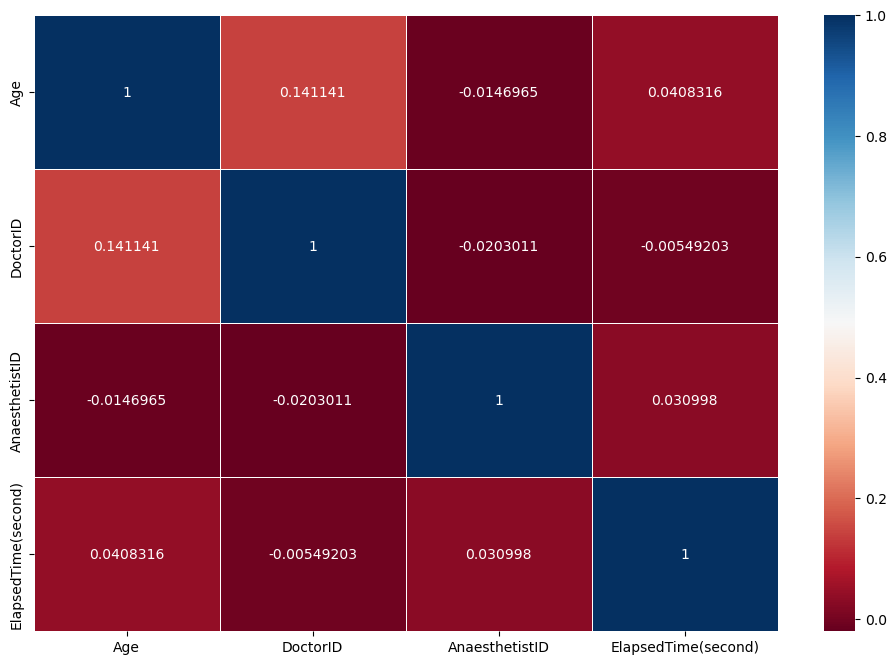

In [28]:
fig = plt.figure(figsize=(12,8))
corr = df.corr()
ax = sns.heatmap(corr, linewidths=.5, cmap="RdBu", annot=True, fmt="g")

# Data Preprocessing


In [29]:
# "age" Analysis:

print(f'Age Variable min: {df["Age"].min()}')
print(f'Age Variable max: {df["Age"].max()}')
print(f'Age Mean: {df["Age"].mean()}')
print(f'Age Variable: {df["Age"].nunique()}')



Age Variable min: 0
Age Variable max: 102
Age Mean: 43.8979447200567
Age Variable: 85


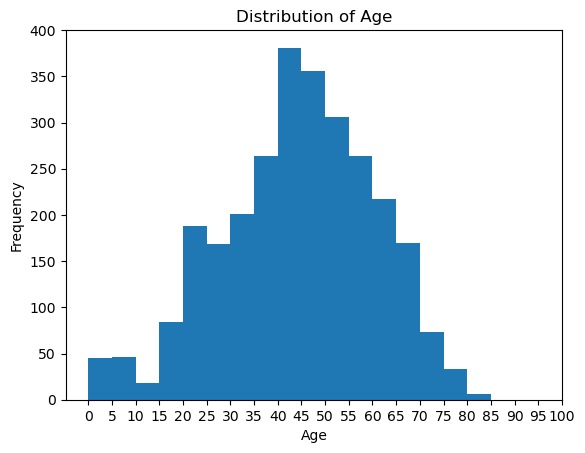

In [30]:
# "Age" kolonundaki verilerin histogram grafiğini çizin
plt.hist(df['Age'], bins=range(0, 100, 5))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.xticks(range(0, 101, 5), [str(i) for i in range(0, 101, 5)])
plt.show()

In [31]:
df['age_cat'] = pd.cut(df['Age'], bins=[0, 18, 30, 45, 60, 100], labels=['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'])

In [32]:
df['age_cat'].unique()


['Teens', 'Adults', 'Mid Adults', 'Children', 'Elderly', NaN]
Categories (5, object): ['Children' < 'Teens' < 'Adults' < 'Mid Adults' < 'Elderly']

In [33]:
df["Age"].value_counts()

44     85
41     82
49     80
40     74
47     74
       ..
80      1
78      1
102     1
0       1
82      1
Name: Age, Length: 85, dtype: int64

In [34]:
df["age_cat"].value_counts()

Mid Adults    913
Adults        874
Elderly       448
Teens         428
Children      157
Name: age_cat, dtype: int64

In [35]:
#SurgeryGroupRate değişkenini sıralı değişken yapmak için hazırlık
def convert_and_choose_max_value(x):
    if 'A1' in x:
        return 7
    elif 'A2' in x:
        return 6
    elif 'A3' in x:
        return 5        
    elif 'B' in x:
        return 4
    elif 'C' in x:
        return 3
    elif 'D' in x:
        return 2
    elif 'E' in x:
        return 1
    elif '0' in x:
        return 0
    else:
        return None

df['SurgeryGroupRate'] = df['SurgeryGroup'].apply(convert_and_choose_max_value)

In [36]:
df.head()

,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),age_cat,SurgeryGroupRate
0,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333,Teens,3
1,{'N20.1'},{'C'},Spinal Anestezi,Ülser veya enflamasyon olmadan alt ekstremiten...,24,MALE,ÜROLOJ? SERV?S?,15,3,2972,Teens,3
2,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647,Adults,4
3,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871,Adults,4
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046,Mid Adults,5


In [37]:
# SurgeryGroupRate sütunundaki NaN değerlerin sayısı
nan_count = df['SurgeryGroupRate'].isnull().sum()

# SurgeryGroupRate sütunundaki NaN değerlerin bulunduğu satırları göster
nan_rows = df[df['SurgeryGroupRate'].isnull()]

# Sonuçları görüntüle
print("SurgeryGroupRate sütunundaki NaN değer sayısı:", nan_count)
print("SurgeryGroupRate sütunundaki NaN değerlerin bulunduğu satırlar:")
print(nan_rows)

SurgeryGroupRate sütunundaki NaN değer sayısı: 0
SurgeryGroupRate sütunundaki NaN değerlerin bulunduğu satırlar:
Empty DataFrame
Columns: [DiagnosticICD10Code, SurgeryGroup, AnesthesiaType, SurgeryName, Age, Sex, Service, DoctorID, AnaesthetistID, ElapsedTime(second), age_cat, SurgeryGroupRate]
Index: []


In [38]:
# "SurgeryGroupRate" Analizi:

print(f'SurgeryGroupRate Variable min: {df["SurgeryGroupRate"].min()}')
print(f'SurgeryGroupRate Variable max: {df["SurgeryGroupRate"].max()}')
print(f'SurgeryGroupRate Variable: {df["SurgeryGroupRate"].nunique()}')

SurgeryGroupRate Variable min: 0
SurgeryGroupRate Variable max: 6
SurgeryGroupRate Variable: 7


In [39]:
df.head()

,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),age_cat,SurgeryGroupRate
0,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333,Teens,3
1,{'N20.1'},{'C'},Spinal Anestezi,Ülser veya enflamasyon olmadan alt ekstremiten...,24,MALE,ÜROLOJ? SERV?S?,15,3,2972,Teens,3
2,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647,Adults,4
3,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871,Adults,4
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046,Mid Adults,5


Binary Encoding:


In [40]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [41]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [42]:
binary_cols


['Sex']

In [43]:
for col in binary_cols:
    label_encoder(df, col)

In [44]:
df.head()

,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),age_cat,SurgeryGroupRate
0,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,1,GENEL CERRAH? SERV?S?,5,13,6333,Teens,3
1,{'N20.1'},{'C'},Spinal Anestezi,Ülser veya enflamasyon olmadan alt ekstremiten...,24,1,ÜROLOJ? SERV?S?,15,3,2972,Teens,3
2,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,1,GENEL CERRAH? SERV?S?,36,14,4647,Adults,4
3,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,0,ORTOPED? SERV?S?,42,6,4871,Adults,4
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,0,ORTOPED? SERV?S?,42,9,9046,Mid Adults,5


# Label Encoding:


In [45]:
labelencoder = LabelEncoder()

In [46]:
cat_cols

['SurgeryGroup',
 'AnesthesiaType',
 'Sex',
 'Service',
 'DoctorID',
 'AnaesthetistID']

In [47]:
df["AnesthesiaType"] = labelencoder.fit_transform(df["AnesthesiaType"])
df["Service"] = labelencoder.fit_transform(df["Service"])
df["age_cat"] = labelencoder.fit_transform(df["age_cat"])
df["SurgeryNameEncoded"] = labelencoder.fit_transform(df["SurgeryName"])


In [48]:
df.head()


,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded
0,{'L05'},{'C'},10,Pilonidal kist,26,1,0,5,13,6333,4,3,172
1,{'N20.1'},{'C'},10,Ülser veya enflamasyon olmadan alt ekstremiten...,24,1,9,15,3,2972,4,3,242
2,{'K80.8'},{'B'},2,"Kolelitiazis, di?er",38,1,0,36,14,4647,0,4,125
3,"{nan, 'M51.1'}","{0, 'B'}",2,Lumbar ve di?er intervertebral disk bozuklukla...,41,0,7,42,6,4871,0,4,143
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",2,Lumbar ve di?er intervertebral disk bozuklukla...,49,0,7,42,9,9046,3,5,143


# One-Hot Encoding:


In [49]:
df["AnaesthetistID"].nunique()

16

In [50]:
df["DoctorID"].nunique()

48

In [51]:
df = pd.get_dummies(df, columns = ['DoctorID', 'AnaesthetistID'], drop_first = True)

In [52]:
df.head()

,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_2,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_7,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_12,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_44,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16
0,{'L05'},{'C'},10,Pilonidal kist,26,1,0,6333,4,3,172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,{'N20.1'},{'C'},10,Ülser veya enflamasyon olmadan alt ekstremiten...,24,1,9,2972,4,3,242,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,{'K80.8'},{'B'},2,"Kolelitiazis, di?er",38,1,0,4647,0,4,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,"{nan, 'M51.1'}","{0, 'B'}",2,Lumbar ve di?er intervertebral disk bozuklukla...,41,0,7,4871,0,4,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",2,Lumbar ve di?er intervertebral disk bozuklukla...,49,0,7,9046,3,5,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## DiagnosticICD10Code düzenlenmesi

In [53]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
  df[i]= df["DiagnosticICD10Code"].apply(lambda x: len([x for x in x.split() if x.__contains__(i)]))
  df[i]


In [54]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
    df[i] = df[i].apply(lambda x: 1 if x > 1 else x)

In [55]:
df.head()

,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_2,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_7,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_12,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_44,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,{'L05'},{'C'},10,Pilonidal kist,26,1,0,6333,4,3,172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,{'N20.1'},{'C'},10,Ülser veya enflamasyon olmadan alt ekstremiten...,24,1,9,2972,4,3,242,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,{'K80.8'},{'B'},2,"Kolelitiazis, di?er",38,1,0,4647,0,4,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,"{nan, 'M51.1'}","{0, 'B'}",2,Lumbar ve di?er intervertebral disk bozuklukla...,41,0,7,4871,0,4,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",2,Lumbar ve di?er intervertebral disk bozuklukla...,49,0,7,9046,3,5,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Gereksiz Kısımların Drop Edilmesi

In [56]:
grouped = df.groupby("SurgeryGroupRate")["SurgeryName"].nunique()
print(grouped)


SurgeryGroupRate
0     19
1     14
2     43
3    118
4    129
5     30
6      1
Name: SurgeryName, dtype: int64


In [57]:
#SurgeryName kısmını drop ediyorum fakat inceleyeceğim
#df["SurgeryName"].nunique()

In [58]:
df.drop(["DiagnosticICD10Code","SurgeryGroup","SurgeryName"], axis=1, inplace=True)


In [59]:
df.head()

,AnesthesiaType,Age,Sex,Service,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_2,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_7,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_12,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_44,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,10,26,1,0,6333,4,3,172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,10,24,1,9,2972,4,3,242,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,38,1,0,4647,0,4,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2,41,0,7,4871,0,4,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2,49,0,7,9046,3,5,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [60]:
#  RobustScaler uygulaması
df["Age"] = RobustScaler().fit_transform(df[["Age"]])

In [61]:
df.head()

,AnesthesiaType,Age,Sex,Service,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_2,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_7,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_12,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_44,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,10,-0.863636,1,0,6333,4,3,172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,10,-0.954545,1,9,2972,4,3,242,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,-0.318182,1,0,4647,0,4,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2,-0.181818,0,7,4871,0,4,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2,0.181818,0,7,9046,3,5,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# Machine Learning Model


In [62]:
# target and independent variables:

y = df["ElapsedTime(second)"]
X = df.drop(["ElapsedTime(second)"], axis=1)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 123,
                                                    test_size = 0.2, 
                                                    shuffle = True)

print(f"The shape of X_train is --> {(X_train.shape)}")
print(f"The shape of X_test is  --> {(X_test.shape)}")
print(f"The shape of y_train is --> {(y_train.shape)}")
print(f"The shape of y_test is  --> {(y_test.shape)}")

The shape of X_train is --> (2257, 91)
The shape of X_test is  --> (565, 91)
The shape of y_train is --> (2257,)
The shape of y_test is  --> (565,)


In [64]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

def evaluate_models(X_train, X_test, y_train, y_test):
    models = [
        LinearRegression(),
        Ridge(),
        Lasso(),
        ElasticNet(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        GradientBoostingRegressor(),
        AdaBoostRegressor(),
        KNeighborsRegressor(),
        MLPRegressor()
    ]
    
    for model in models:
        model_name = type(model).__name__
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        print(f'{model_name}:')
        print(f'Train RMSE: {train_rmse:.2f}')
        print(f'Test RMSE: {test_rmse:.2f}')
        print(f'Train R^2: {train_r2:.2f}')
        print(f'Test R^2: {test_r2:.2f}')
        print('-------------------------------------------------------')


In [65]:
from sklearn.metrics import r2_score
evaluate_models(X_train, X_test, y_train, y_test)

LinearRegression:
Train RMSE: 1894.65
Test RMSE: 1979.70
Train R^2: 0.61
Test R^2: 0.58
-------------------------------------------------------
Ridge:
Train RMSE: 1900.04
Test RMSE: 1975.92
Train R^2: 0.61
Test R^2: 0.58
-------------------------------------------------------
Lasso:
Train RMSE: 1899.72
Test RMSE: 1972.45
Train R^2: 0.61
Test R^2: 0.58
-------------------------------------------------------
ElasticNet:
Train RMSE: 2390.45
Test RMSE: 2428.73
Train R^2: 0.38
Test R^2: 0.36
-------------------------------------------------------
DecisionTreeRegressor:
Train RMSE: 82.85
Test RMSE: 2200.75
Train R^2: 1.00
Test R^2: 0.48
-------------------------------------------------------
RandomForestRegressor:
Train RMSE: 598.20
Test RMSE: 1730.90
Train R^2: 0.96
Test R^2: 0.68
-------------------------------------------------------
GradientBoostingRegressor:
Train RMSE: 1419.27
Test RMSE: 1688.01
Train R^2: 0.78
Test R^2: 0.69
-------------------------------------------------------
AdaB

Kullanacağım model RandomForestRegressor olarak seçtim test.csv dosyasını yükleyip gerekli işlemleri yapacağım


In [66]:
df_test = pd.read_csv("/kaggle/input/prediction-of-surgery-duration/test.csv",encoding='Latin-1')

In [67]:
df_test.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID
0,1669,{'H26.9'},{'C'},Sedo Analjezi,NaN,70,FEMALE,GÖZ HASTALIKLARI SERV?S?,49,13
1,2091,{'L05.9'},{'C'},Spinal Anestezi,Pilonidal kist,41,MALE,GENEL CERRAH? SERV?S?,36,6
2,585,{'M50.1'},{'A3'},Genel Anestezi,"Servikal disk bozukluklar?, radikülopati ile",59,FEMALE,ORTOPED? SERV?S?,42,14
3,1455,{'S42.2'},{'B'},Genel Anestezi,Humerus üst uç k?r???,54,FEMALE,ORTOPED? SERV?S?,23,14
4,1801,{'I82'},"{0, 'E'}",Sedo Analjezi,Ülser veya enflamasyon olmadan alt ekstremiten...,50,MALE,KVC SERV?S?,46,13


In [68]:
# AnesthesiaType sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df_test["AnesthesiaType"].isnull().sum().astype(str))

df_test["AnesthesiaType"].fillna("Genel Anestezi", inplace=True)

print("Boşluk doldurma sonrası boş değer sayısı:" + df_test["AnesthesiaType"].isnull().sum().astype(str))


Boşluk doldurma öncesi boş değer sayısı:95
Boşluk doldurma sonrası boş değer sayısı:0


In [69]:
# SurgeryName sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df_test["SurgeryName"].isnull().sum().astype(str))
df_test['SurgeryName'] = df_test['SurgeryName'].fillna(df_test['SurgeryName'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df_test["SurgeryName"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:149
Boşluk doldurma sonrası boş değer sayısı:0


In [70]:
# DiagnosticICD10Code sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df_test["DiagnosticICD10Code"].isnull().sum().astype(str))
df_test['DiagnosticICD10Code'] = df_test['DiagnosticICD10Code'].fillna(df_test['DiagnosticICD10Code'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df_test["DiagnosticICD10Code"].isnull().sum().astype(str))


Boşluk doldurma öncesi boş değer sayısı:95
Boşluk doldurma sonrası boş değer sayısı:0


In [71]:
df_test['age_cat'] = pd.cut(df_test['Age'], bins=[0, 18, 30, 45, 60, 100], labels=['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'])

In [72]:
def grab_col_names(dataframe, cat_th=50, car_th=100):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols_test, num_cols_test, cat_but_car_test = grab_col_names(df_test)

Observations: 1211
Variables: 11
cat_cols: 7
num_cols: 2
cat_but_car: 2
num_but_cat: 3


In [73]:
#SurgeryGroupRate değişkenini sıralı değişken yapmak için hazırlık
def convert_and_choose_max_value(x):
    if 'A1' in x:
        return 7
    elif 'A2' in x:
        return 6
    elif 'A3' in x:
        return 5        
    elif 'B' in x:
        return 4
    elif 'C' in x:
        return 3
    elif 'D' in x:
        return 2
    elif 'E' in x:
        return 1
    elif '0' in x:
        return 0
    else:
        return None

df_test['SurgeryGroupRate'] = df_test['SurgeryGroup'].apply(convert_and_choose_max_value)

In [74]:
binary_cols_test = [col for col in df_test.columns if df_test[col].dtype not in [int, float]
               and df_test[col].nunique() == 2]

In [75]:
binary_cols_test

['Sex']

In [76]:
label_encoder(df_test, 'Sex')

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,age_cat,SurgeryGroupRate
0,1669,{'H26.9'},{'C'},Sedo Analjezi,Ülser veya enflamasyon olmadan alt ekstremiten...,70,0,GÖZ HASTALIKLARI SERV?S?,49,13,Elderly,3
1,2091,{'L05.9'},{'C'},Spinal Anestezi,Pilonidal kist,41,1,GENEL CERRAH? SERV?S?,36,6,Adults,3
2,585,{'M50.1'},{'A3'},Genel Anestezi,"Servikal disk bozukluklar?, radikülopati ile",59,0,ORTOPED? SERV?S?,42,14,Mid Adults,5
3,1455,{'S42.2'},{'B'},Genel Anestezi,Humerus üst uç k?r???,54,0,ORTOPED? SERV?S?,23,14,Mid Adults,4
4,1801,{'I82'},"{0, 'E'}",Sedo Analjezi,Ülser veya enflamasyon olmadan alt ekstremiten...,50,1,KVC SERV?S?,46,13,Mid Adults,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1206,1599,{'I83.9'},{'B'},Genel Anestezi,"Gövdenin lokalize ?i?me, kitle ve yumrusu",23,0,GENEL CERRAH? SERV?S?,36,11,Teens,4
1207,41,{'I83.9'},{'B'},Genel Anestezi,"Tibian?n alt uç k?r???, kapal?",56,0,ORTOPED? SERV?S?,23,8,Mid Adults,4
1208,1,{'I83.9'},"{'D', 'C'}",Genel Anestezi,Nazal septum deviasyonu,32,0,KBB SERV?S?,37,1,Adults,3
1209,24,{'I83.9'},"{'D', 'C'}",Genel Anestezi,Anal fissür tan?mlanmam??,18,0,GENEL CERRAH? SERV?S?,3,2,Children,3


In [77]:
labelencoder = LabelEncoder()

In [78]:
df_test["AnesthesiaType"] = labelencoder.fit_transform(df_test["AnesthesiaType"])
df_test["Service"] = labelencoder.fit_transform(df_test["Service"])
df_test["age_cat"] = labelencoder.fit_transform(df_test["age_cat"])
df_test["SurgeryNameEncoded"] = labelencoder.fit_transform(df_test["SurgeryName"])


In [79]:
df_test.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,age_cat,SurgeryGroupRate,SurgeryNameEncoded
0,1669,{'H26.9'},{'C'},6,Ülser veya enflamasyon olmadan alt ekstremiten...,70,0,3,49,13,2,3,179
1,2091,{'L05.9'},{'C'},7,Pilonidal kist,41,1,1,36,6,0,3,129
2,585,{'M50.1'},{'A3'},2,"Servikal disk bozukluklar?, radikülopati ile",59,0,8,42,14,3,5,150
3,1455,{'S42.2'},{'B'},2,Humerus üst uç k?r???,54,0,8,23,14,3,4,84
4,1801,{'I82'},"{0, 'E'}",6,Ülser veya enflamasyon olmadan alt ekstremiten...,50,1,6,46,13,3,1,179


In [80]:
df_test = pd.get_dummies(df_test, columns = ['DoctorID', 'AnaesthetistID'], drop_first = True)

In [81]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
  df_test[i]= df_test["DiagnosticICD10Code"].apply(lambda x: len([x for x in x.split() if x.__contains__(i)]))
  df_test[i]

In [82]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
    df_test[i] = df_test[i].apply(lambda x: 1 if x > 1 else x)

In [83]:
df_test.drop(["DiagnosticICD10Code","SurgeryGroup","SurgeryName"], axis=1, inplace=True)

In [84]:
# Let's scaling with RobustScaler
df_test["Age"] = RobustScaler().fit_transform(df_test[["Age"]])

In [85]:
df_test.head()

,ID,AnesthesiaType,Age,Sex,Service,age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_38,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,1669,6,1.086957,0,3,2,3,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2091,7,-0.173913,1,1,0,3,129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,585,2,0.608696,0,8,3,5,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1455,2,0.391304,0,8,3,4,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1801,6,0.217391,1,6,3,1,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
df_train = df.copy()

In [87]:
df_train.head()

,AnesthesiaType,Age,Sex,Service,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_2,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_7,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_12,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_44,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,10,-0.863636,1,0,6333,4,3,172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,10,-0.954545,1,9,2972,4,3,242,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,-0.318182,1,0,4647,0,4,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2,-0.181818,0,7,4871,0,4,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2,0.181818,0,7,9046,3,5,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [88]:
df_test1 = df_test.copy()

In [89]:
df_test1.drop("ID", axis=1, inplace=True)

In [90]:
df_test1.shape

(1211, 88)

In [91]:
df_train.shape

(2822, 92)

In [92]:
# df_train veri kümesindeki sütun adlarını alın
train_columns = df_train.columns

# df_test veri kümesindeki sütun adlarını alın
test_columns = df_test1.columns

# df_train'de eksik olan sütunları df_test veri kümesine ekleyin
missing_columns = train_columns.difference(test_columns)
for column in missing_columns:
    df_test1[column] = 0


In [93]:
missing_columns = set(df_train.columns) - set(df_test1.columns)
print(missing_columns)


set()


In [94]:

df_test1.columns

Index(['AnesthesiaType', 'Age', 'Sex', 'Service', 'age_cat', 'SurgeryGroupRate', 'SurgeryNameEncoded', 'DoctorID_3', 'DoctorID_4', 'DoctorID_5', 'DoctorID_6', 'DoctorID_8', 'DoctorID_9', 'DoctorID_10', 'DoctorID_11', 'DoctorID_13', 'DoctorID_14', 'DoctorID_15', 'DoctorID_16', 'DoctorID_17', 'DoctorID_18', 'DoctorID_19', 'DoctorID_20', 'DoctorID_21', 'DoctorID_22', 'DoctorID_23', 'DoctorID_24', 'DoctorID_25', 'DoctorID_26', 'DoctorID_27', 'DoctorID_28', 'DoctorID_29', 'DoctorID_30',
       'DoctorID_31', 'DoctorID_32', 'DoctorID_33', 'DoctorID_34', 'DoctorID_35', 'DoctorID_36', 'DoctorID_37', 'DoctorID_38', 'DoctorID_39', 'DoctorID_40', 'DoctorID_41', 'DoctorID_42', 'DoctorID_43', 'DoctorID_45', 'DoctorID_46', 'DoctorID_47', 'DoctorID_48', 'DoctorID_49', 'AnaesthetistID_2', 'AnaesthetistID_3', 'AnaesthetistID_4', 'AnaesthetistID_5', 'AnaesthetistID_6', 'AnaesthetistID_7', 'AnaesthetistID_8', 'AnaesthetistID_9', 'AnaesthetistID_10', 'AnaesthetistID_11', 'AnaesthetistID_12',
       'Anaes

In [95]:
df_train.columns

Index(['AnesthesiaType', 'Age', 'Sex', 'Service', 'ElapsedTime(second)', 'age_cat', 'SurgeryGroupRate', 'SurgeryNameEncoded', 'DoctorID_2', 'DoctorID_3', 'DoctorID_4', 'DoctorID_5', 'DoctorID_6', 'DoctorID_7', 'DoctorID_8', 'DoctorID_9', 'DoctorID_10', 'DoctorID_11', 'DoctorID_12', 'DoctorID_13', 'DoctorID_14', 'DoctorID_15', 'DoctorID_16', 'DoctorID_17', 'DoctorID_18', 'DoctorID_19', 'DoctorID_20', 'DoctorID_21', 'DoctorID_22', 'DoctorID_23', 'DoctorID_24', 'DoctorID_25', 'DoctorID_26',
       'DoctorID_27', 'DoctorID_28', 'DoctorID_29', 'DoctorID_30', 'DoctorID_31', 'DoctorID_32', 'DoctorID_33', 'DoctorID_34', 'DoctorID_35', 'DoctorID_36', 'DoctorID_37', 'DoctorID_39', 'DoctorID_40', 'DoctorID_41', 'DoctorID_42', 'DoctorID_43', 'DoctorID_44', 'DoctorID_45', 'DoctorID_46', 'DoctorID_47', 'DoctorID_48', 'DoctorID_49', 'AnaesthetistID_2', 'AnaesthetistID_3', 'AnaesthetistID_4', 'AnaesthetistID_5', 'AnaesthetistID_6', 'AnaesthetistID_7', 'AnaesthetistID_8', 'AnaesthetistID_9',
       'An

In [96]:
# df_test1 ve df_train veri çerçevelerindeki sütun sayılarını bulun
print("df_test1 sütun sayısı:", df_test1.shape[1])
print("df_train sütun sayısı:", df_train.shape[1])


df_test1 sütun sayısı: 93
df_train sütun sayısı: 92


In [97]:
df_test1.drop("DoctorID_38", axis=1, inplace=True)

In [98]:
columns = df_train.columns


In [99]:
df_test1 = df_test1[columns]


In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Özelliklerin ve hedef değişkenin ayrılması
X_train = df_train.drop('ElapsedTime(second)', axis=1)
y_train = df_train['ElapsedTime(second)']
X_test = df_test1.drop('ElapsedTime(second)', axis=1)
y_test = df_test1['ElapsedTime(second)']


# Modelin Eğitilmesi ve Hiperparametre Optimizasyonu

In [101]:
# Grid search için parametrelerin belirlenmesi
param_grid = {'n_estimators': [420,419], 'max_depth': [22], 'min_samples_leaf': [2]}

# Random forest modeli oluşturma
model = RandomForestRegressor(random_state=42)

# Grid search modeli oluşturma
search_rf = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

In [102]:
# Modelin eğitimi
search_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [22], 'min_samples_leaf': [2],
                         'n_estimators': [420, 419]},
             scoring='neg_root_mean_squared_error')

In [103]:
# En iyi parametreleri  yazdırma
print("Best Parameters: ", search_rf.best_params_)


# Modelin en iyi parametrelerle eğitilmesi
model = RandomForestRegressor(**search_rf.best_params_, random_state=42)
model.fit(X_train, y_train)

# Tahminlerin yapılması ve df_test1 üzerine yazılması
df_test1['ElapsedTime(second)'] = model.predict(X_test)

Best Parameters:  {'max_depth': 22, 'min_samples_leaf': 2, 'n_estimators': 419}


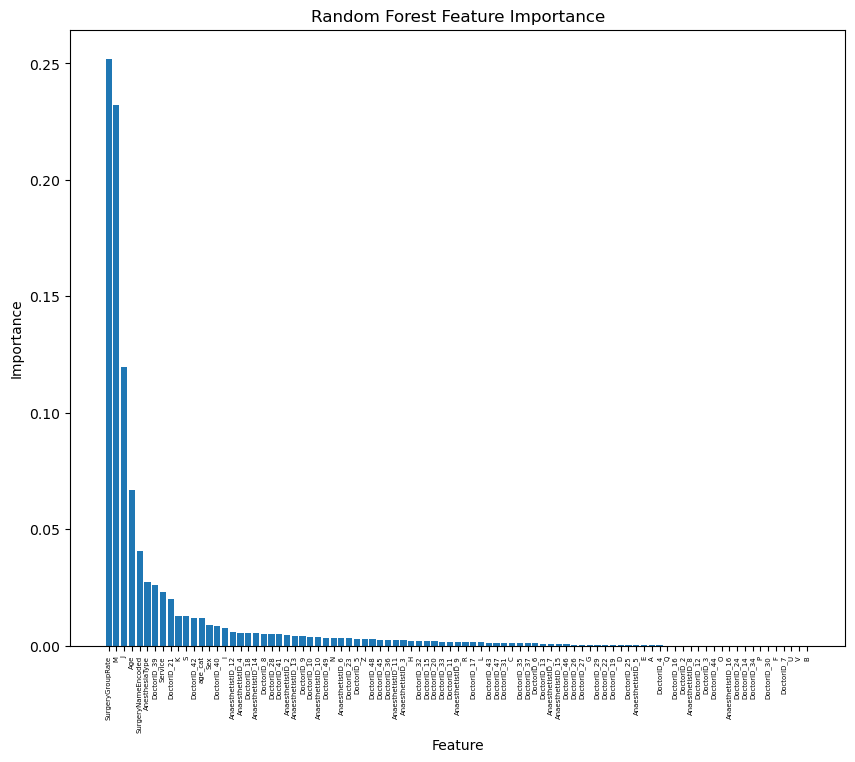

In [104]:
# özellik önemlerini bir dizi olarak al
importances = model.feature_importances_

# özelliklerin isimlerini bir dizi olarak al
feature_names = X_train.columns

# özellik isimleri ve önemleri içeren bir veri çerçevesi oluştur
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Önemliliğe göre sırala
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Veri çerçevesini kullanarak bir bar grafik oluştur
plt.figure(figsize=(10,8))
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90,fontsize=5)
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [105]:
threshold = 0.000005
low_importance_cols = feature_importances[feature_importances['importance'] < threshold]['feature'].values
X_train_new = X_train.drop(low_importance_cols, axis=1)
X_test_new = X_test.drop(low_importance_cols, axis=1)

In [106]:
X_train_new.shape

(2822, 77)

In [107]:
model.fit(X_train_new,y_train)


RandomForestRegressor(max_depth=22, min_samples_leaf=2, n_estimators=419,
                      random_state=42)

In [108]:
# Tahminlerin yapılması ve df_test1 üzerine yazılması
df_test1['ElapsedTime(second)'] = model.predict(X_test_new)

In [109]:
df_test1['ElapsedTime(second)']

0       2599.794097
1       2070.983663
2       8345.157179
3       7882.382649
4       2762.180661
           ...     
1206    2546.066147
1207    4857.641264
1208    4502.009615
1209    4463.833875
1210    3567.018241
Name: ElapsedTime(second), Length: 1211, dtype: float64

In [110]:
df_test1.head()

,AnesthesiaType,Age,Sex,Service,ElapsedTime(second),age_cat,SurgeryGroupRate,SurgeryNameEncoded,DoctorID_2,DoctorID_3,DoctorID_4,DoctorID_5,DoctorID_6,DoctorID_7,DoctorID_8,DoctorID_9,DoctorID_10,DoctorID_11,DoctorID_12,DoctorID_13,DoctorID_14,DoctorID_15,DoctorID_16,DoctorID_17,DoctorID_18,DoctorID_19,DoctorID_20,DoctorID_21,DoctorID_22,DoctorID_23,DoctorID_24,DoctorID_25,DoctorID_26,DoctorID_27,DoctorID_28,DoctorID_29,DoctorID_30,DoctorID_31,DoctorID_32,DoctorID_33,DoctorID_34,DoctorID_35,DoctorID_36,DoctorID_37,DoctorID_39,DoctorID_40,DoctorID_41,DoctorID_42,DoctorID_43,DoctorID_44,DoctorID_45,DoctorID_46,DoctorID_47,DoctorID_48,DoctorID_49,AnaesthetistID_2,AnaesthetistID_3,AnaesthetistID_4,AnaesthetistID_5,AnaesthetistID_6,AnaesthetistID_7,AnaesthetistID_8,AnaesthetistID_9,AnaesthetistID_10,AnaesthetistID_11,AnaesthetistID_12,AnaesthetistID_13,AnaesthetistID_14,AnaesthetistID_15,AnaesthetistID_16,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,6,1.086957,0,3,2599.794097,2,3,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,-0.173913,1,1,2070.983663,0,3,129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,0.608696,0,8,8345.157179,3,5,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2,0.391304,0,8,7882.382649,3,4,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,6,0.217391,1,6,2762.180661,3,1,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:


# submission.csv dosyasının oluşturulması
submission = pd.DataFrame({'ID': df_test['ID'], 'ElapsedTime(second)': df_test1['ElapsedTime(second)']})
submission.to_csv('submission.csv', index=False)
